# Usporedba ljudskog, Edgarovog automatskog i LLM ocjenjivanja studentskih rješenja

## Uvod

Tema ovog projekta bavi se usporedbom triju pristupa ocjenjivanju studentskih radova; ljudskog, Edgarovog automatskog i onog temeljenog na velikim jezičnim modelima (LLM). Poseban naglasak stavlja se na potencijal LLM-a da kombinira prednosti ljudskog prosuđivanja i automatizirane obrade.  

Tradicionalno ljudsko ocjenjivanje studentskih radova omogućuje uvažavanje rješenja koja ne slijede standardne obrasce, jednostavno parcijalno bodovanje rješenja koja ne dovode do točnog rezultata, ali koriste djelomično točan postupak, te kaznu rješenja koja dolaze do točnog odgovora na nepoželjan način. Glavni nedostatci su velika vremenska zahtjevnost i potreba za većim brojem kvalificiranih ocjenjivača, kao i subjektivnost ocjenjivača, koja se može djelomično ublažiti postavljanjem kriterija ocjenjivanja.  

Automatsko ocjenjivanje omogućuje brzo i konzistentno ocjenjivanje, ali je često teško postići fleksibilnost koju pruža ljudski ocjenjivač.  

U okviru ovog projekta fokus je na ocjenjivanju jednostavnih studentskih programskih rješenja namijenjenih rješavanju specifičnih problema, konkretno zadataka s kolegija "Uvod u programiranje". Studentska rješenja trenutačno se provjeravaju automatski putem sustava Edgar, koji ispituje točnost izlaza za unaprijed definirane ulaze, te naknadno ljudskom provjerom kojom se procjenjuje i boduje rješenje.  

U posljednje vrijeme LLM-ovi postižu napredak u razumijevanju jezika i koda, što otvara mogućnost njihove primjene i u ocjenjivanju studentskih programskih rješenja.  

## Cilj projekta

Cilj projekta je provesti kvantitativnu i kvalitativnu usporednu analizu između ljudskog, automatskog i LLM pristupa ocjenjivanja studentskih programskih rješenja. U tu svrhu odabrana su dva LLM-a te su osmišljeni upiti koji će davati poželjne odgovore na studentska rješenja zadataka.  

___

# Učitavanje i čišćenje podataka

U ovoj sekciji učitavamo glavnu dataset datoteku `studentTestQuestion.csv`, 
koja sadrži podatke o automatskom (Edgar) i ručnom (manualnom) ocjenjivanju 
studentskih programskih rješenja.

Zatim pripremamo podatke za daljnju analizu. Provjeravamo tipove podataka, konvertiramo numeričke stupce i uklanjamo redove koji nemaju stvarno manualno ocjenjivanje.
Također bilježimo broj nedostajućih vrijednosti po stupcu kako bismo imali pregled kvalitete podataka prije statističkih analiza.




In [18]:
import pandas as pd
import numpy as np

# Učitavanje CSV-a
df = pd.read_csv("studentTestQuestion.csv", sep=';', engine='python')

print(f"Dimenzije podataka (redovi, stupci): {df.shape}")
print("Nazivi stupaca:")
print(df.columns.tolist())
print("\nPrvih 5 redova:")
display(df.head())

# Provjera tipova i konverzija numeričkih stupaca
numeric_cols = [
    'test_max_score', 'test_score_ed', 'test_score_man',
    'test_score_perc_ed', 'test_score_perc_man',
    'question_score_ed', 'question_score_man',
    'question_score_perc_ed', 'question_score_perc_man',
    'diff_perc'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nTipovi podataka nakon konverzije:")
print(df.dtypes)

# Uklanjanje redaka bez stvarnog manualnog ocjenjivanja
# Pravilo: question_score_man == 0 i id_app_user == 0 ili NaN
condition_no_manual = (
    (df['question_score_man'] == 0) &
    ((df['id_app_user'] == 0) | (df['id_app_user'].isna()))
)
removed_count = condition_no_manual.sum()
print(f"\nBroj redaka bez stvarnog manualnog ocjenjivanja: {removed_count}")

df = df[~condition_no_manual]
print(f"Dimenzije nakon uklanjanja: {df.shape}")

# Provjera nedostajućih vrijednosti
print("\nBroj nedostajućih vrijednosti po stupcu:")
display(df.isna().sum())

print("\nOpisna statistika numeričkih stupaca:")
display(df[numeric_cols].describe())


Dimenzije podataka (redovi, stupci): (1000, 18)
Nazivi stupaca:
['id_test', 'id_test_instance', 'id_academic_year', 'title', 'id_student', 'test_max_score', 'test_score_ed', 'test_score_man', 'test_score_perc_ed', 'test_score_perc_man', 'id_question', 'student_answer_code', 'id_app_user', 'question_score_ed', 'question_score_man', 'question_score_perc_ed', 'question_score_perc_man', 'diff_perc']

Prvih 5 redova:


,id_test,id_test_instance,id_academic_year,title,id_student,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,id_question,student_answer_code,id_app_user,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
0,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,47999,\r\n\r\n\r\n\r\n#include <ctype.h>\r\n#include...,1176.0,10.0,0.0,1.0,0.0,1.0
1,14529,330776,2023,Završni ispit 2023/24 - prvi termin,8863,40.0,30.0,22.0,0.75,0.55,48002,"int k = 0;\r\n long long int polje[48] = {0, 1...",1030.0,10.0,0.0,1.0,0.0,1.0
2,14530,331780,2023,Završni ispit 2023/24 - drugi termin,9050,40.0,30.0,20.0,0.75,0.50,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1003.0,10.0,0.0,1.0,0.0,1.0
3,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1176.0,10.0,0.0,1.0,0.0,1.0
4,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48019,\r\n\r\n\r\n\r\nint brojiDjelj3Kumulativno(int...,1176.0,10.0,0.0,1.0,0.0,1.0



Tipovi podataka nakon konverzije:
id_test                      int64
id_test_instance             int64
id_academic_year             int64
title                       object
id_student                   int64
test_max_score             float64
test_score_ed              float64
test_score_man             float64
test_score_perc_ed         float64
test_score_perc_man        float64
id_question                  int64
student_answer_code         object
id_app_user                float64
question_score_ed          float64
question_score_man         float64
question_score_perc_ed     float64
question_score_perc_man    float64
diff_perc                  float64
dtype: object

Broj redaka bez stvarnog manualnog ocjenjivanja: 4
Dimenzije nakon uklanjanja: (996, 18)

Broj nedostajućih vrijednosti po stupcu:


id_test                    0
id_test_instance           0
id_academic_year           0
title                      0
id_student                 0
test_max_score             0
test_score_ed              0
test_score_man             0
test_score_perc_ed         0
test_score_perc_man        0
id_question                0
student_answer_code        3
id_app_user                6
question_score_ed          0
question_score_man         0
question_score_perc_ed     0
question_score_perc_man    0
diff_perc                  0
dtype: int64


Opisna statistika numeričkih stupaca:


,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,42.138554,25.099166,24.722164,0.605603,0.603706,8.622238,6.834789,0.812717,0.664367,0.148349
std,10.151856,11.718218,11.157860,0.270368,0.266004,4.308865,4.143348,0.344701,0.375483,0.233130
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,17.500000,17.500000,0.438000,0.433000,7.500000,3.500000,0.750000,0.400000,0.000000
50%,40.000000,25.000000,25.750000,0.625000,0.625000,10.000000,8.000000,1.000000,0.850000,0.050000
75%,40.000000,32.500000,33.000000,0.813000,0.813000,10.000000,10.000000,1.000000,1.000000,0.200000
max,70.000000,70.000000,67.300000,1.000000,1.000000,18.000000,17.500000,1.000000,1.000000,1.000000


___

# Usporedba Edgarovog i manualnog ocjenjivanja

## 1) Osnovne metrike i usporedbe

U ovom odsječku izračunat ćemo i vizualizirati osnovne metrike razlika između Edgarovog i manualnog ocjenjivanja izražene kao postotci (diff_perc).
Vizualiziramo distribuciju razlika pomoću histograma i boxplota te provjeravamo eventualne outliere i osnovnu linearnu povezanost (regresija) između Edgarovih i manualnih ocjena.


Osnovne deskriptivne metrike (diff_perc):
Mean: 0.1483
Median: 0.0500
Std Dev: 0.2331
Min: 0.0000
Max: 1.0000


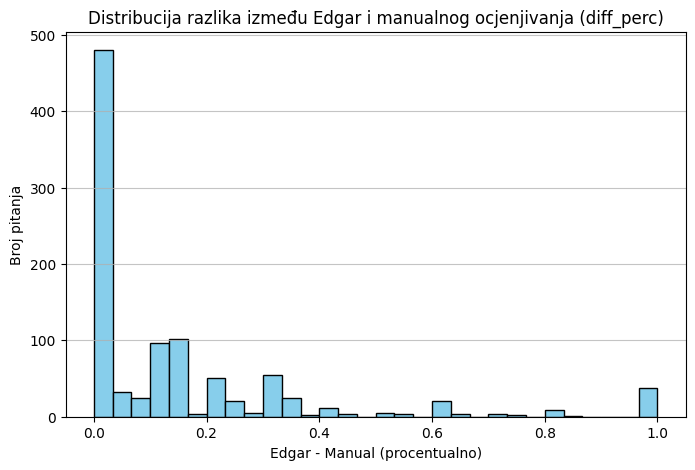

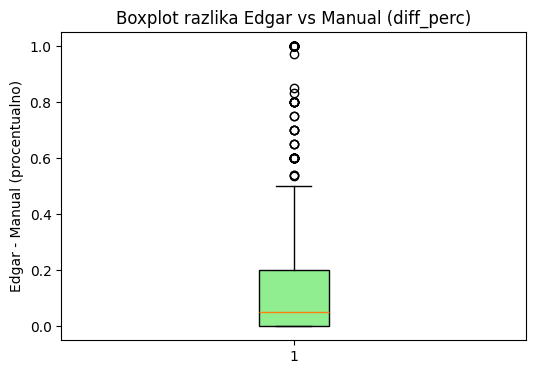

Broj outliera: 80
Primjeri outliera:


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: diff_perc, dtype: float64


Linear regression: Manual = slope*Edgar + intercept
Slope: 0.8646, Intercept: -0.0383
R^2: 0.6300, p-value: 8.3276e-217


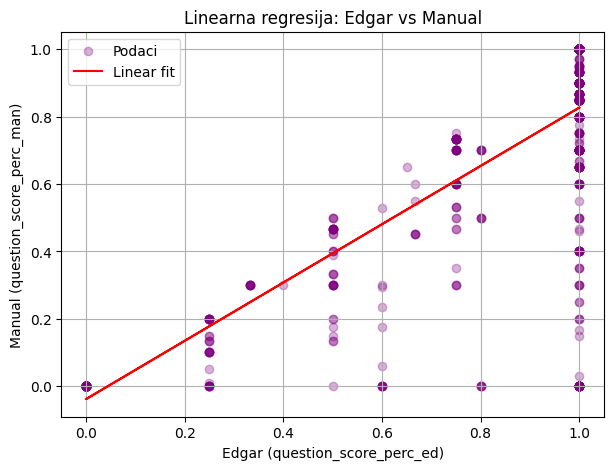

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

diff = df['diff_perc']  # diff_perc = question_score_perc_ed - question_score_perc_man

mean_diff = diff.mean()
median_diff = diff.median()
std_diff = diff.std()
min_diff = diff.min()
max_diff = diff.max()

print("Osnovne deskriptivne metrike (diff_perc):")
print(f"Mean: {mean_diff:.4f}")
print(f"Median: {median_diff:.4f}")
print(f"Std Dev: {std_diff:.4f}")
print(f"Min: {min_diff:.4f}")
print(f"Max: {max_diff:.4f}")

# --- Histogram ---
plt.figure(figsize=(8,5))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribucija razlika između Edgar i manualnog ocjenjivanja (diff_perc)")
plt.xlabel("Edgar - Manual (procentualno)")
plt.ylabel("Broj pitanja")
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Boxplot ---
plt.figure(figsize=(6,4))
plt.boxplot(diff, vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title("Boxplot razlika Edgar vs Manual (diff_perc)")
plt.ylabel("Edgar - Manual (procentualno)")
plt.show()

# --- Provjera outliera ---
q1 = diff.quantile(0.25)
q3 = diff.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
outliers = diff[(diff < lower_bound) | (diff > upper_bound)]
print(f"Broj outliera: {len(outliers)}")
print("Primjeri outliera:")
display(outliers.head(10))

# --- Linearna regresija ---
edgar = df['question_score_perc_ed']
manual = df['question_score_perc_man']

slope, intercept, r_value, p_value, std_err = stats.linregress(edgar, manual)

print(f"\nLinear regression: Manual = slope*Edgar + intercept")
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")
print(f"R^2: {r_value**2:.4f}, p-value: {p_value:.4e}")

# Plot
plt.figure(figsize=(7,5))
plt.scatter(edgar, manual, alpha=0.3, color='purple', label='Podaci')
plt.plot(edgar, intercept + slope*edgar, color='red', label='Linear fit')
plt.xlabel("Edgar (question_score_perc_ed)")
plt.ylabel("Manual (question_score_perc_man)")
plt.title("Linearna regresija: Edgar vs Manual")
plt.legend()
plt.grid(True)
plt.show()


## 3) Analiza po akademskoj godini

U ovom koraku analiziramo razlike između Edgarovog i manualnog ocjenjivanja (diff_perc) po akademskim godinama.
Cilj je otkriti jesu li neke godine “problematičnije”, jesu li ocjenjivači konzistentni unutar godine, te kako se razlikuju distribucije bodova.
Za svaku godinu vizualiziramo distribuciju diff_perc pomoću histograma i boxplota, provodimo Bland–Altman analizu, te prikazujemo tablicu srednjih razlika.

### Histogram po akademskoj godini

Histogram pokazuje raspodjelu razlika (diff_perc) unutar svake godine. Poželjno je vizualizirati da li su razlike između Edgarovog i manualnog ocjenjivanja ravnomjerno raspoređene ili postoje skupine/ekstremi.

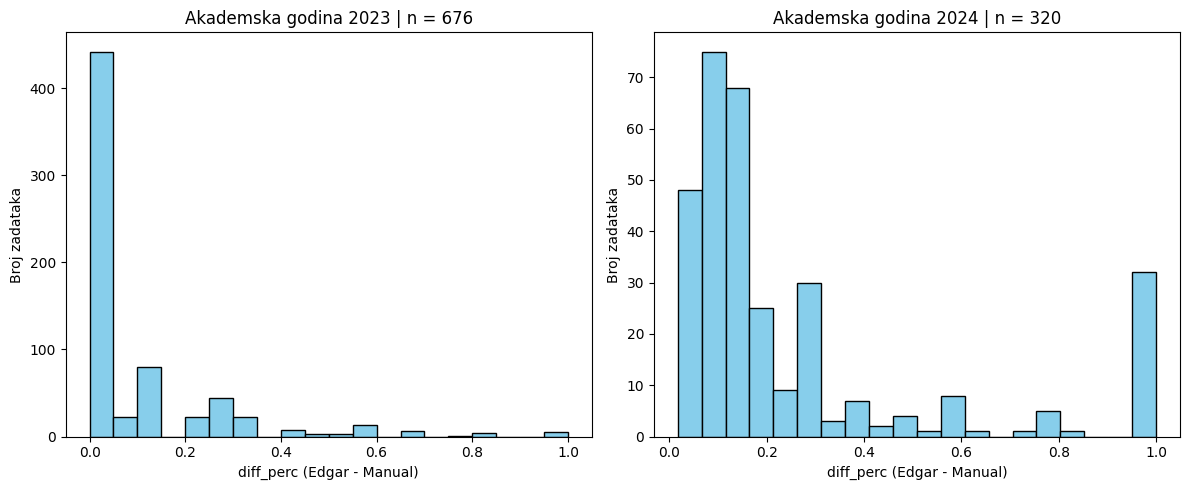

In [20]:
import matplotlib.pyplot as plt

years = sorted(df['id_academic_year'].dropna().unique())

fig, axes = plt.subplots(1, len(years), figsize=(6*len(years), 5))
if len(years) == 1:  # Ako je samo jedna godina, axes nije lista
    axes = [axes]

for ax, year in zip(axes, years):
    data_year = df[df['id_academic_year'] == year]['diff_perc']
    ax.hist(data_year, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Akademska godina {year} | n = {len(data_year)}')
    ax.set_xlabel('diff_perc (Edgar - Manual)')
    ax.set_ylabel('Broj zadataka')

plt.tight_layout()
plt.show()


### Boxplot po akademskoj godini

Boxplot prikazuje medijan, kvartile i outliere diff_perc po godinama. Pomaže da se odmah vizualno uoče ekstremi i opseg razlika.

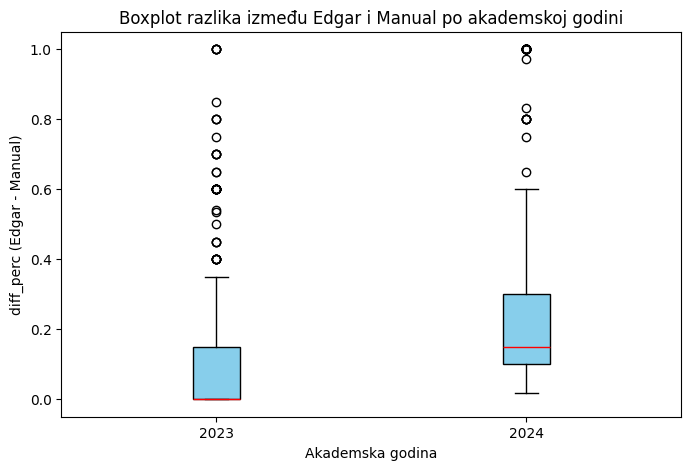

In [26]:
import matplotlib.pyplot as plt

years = sorted(df['id_academic_year'].dropna().unique())
data_by_year = [df[df['id_academic_year']==year]['diff_perc'] for year in years]

plt.figure(figsize=(8,5))
plt.boxplot(
    data_by_year, 
    tick_labels=years,  # <--- promijenjeno
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)


plt.title('Boxplot razlika između Edgar i Manual po akademskoj godini')
plt.xlabel('Akademska godina')
plt.ylabel('diff_perc (Edgar - Manual)')
plt.show()


### 2D density plot po akademskoj godini

U ovom dijelu prikazujemo 2D gustosni (dense) plot za odnos bodova koje je dao Edgar i bodova koje je dao manualni ocjenjivač, po akademskoj godini.
* X-os: question_score_perc_ed (Edgar)
* Y-os: question_score_perc_man (manualno)

Boja označava gustoću pojavljivanja točaka.

Ovaj pristup je posebno koristan kada imamo puno podataka, jer scatter plot može biti pretrpan. Dense plot omogućuje vizualno uočavanje regija gdje se ocjene slažu i gdje postoje značajnije razlike, a može nam i pomoći u prepoznavanju outliera.

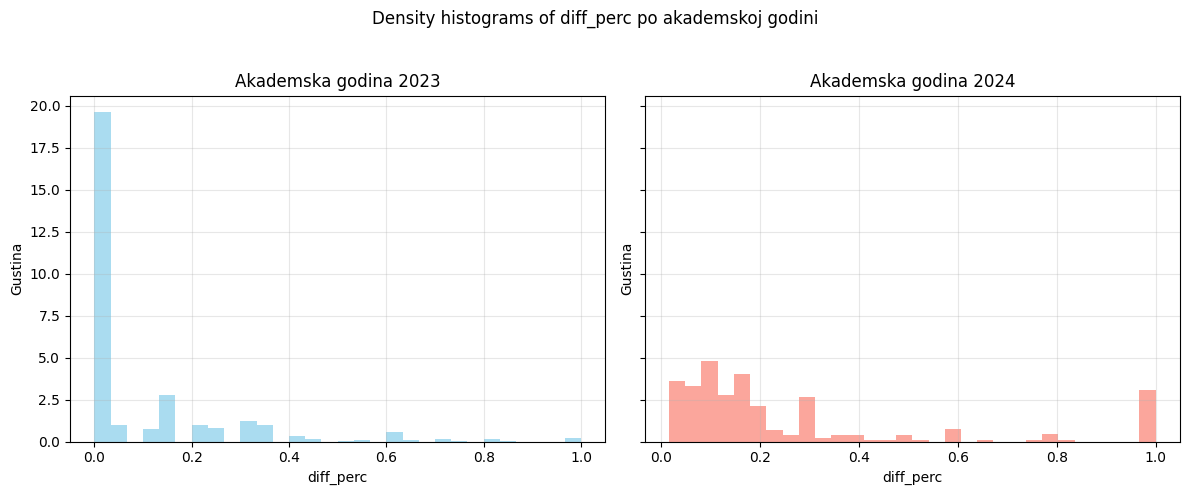

In [50]:
import matplotlib.pyplot as plt

years = sorted(df['id_academic_year'].unique())
fig, axes = plt.subplots(1, len(years), figsize=(12, 5), sharey=True)
colors = ['skyblue', 'salmon']

for ax, year, color in zip(axes, years, colors):
    subset = df[df['id_academic_year'] == year]
    ax.hist(subset['diff_perc'], bins=30, density=True, color=color, alpha=0.7)
    ax.set_title(f'Akademska godina {year}')
    ax.set_xlabel('diff_perc')
    ax.set_ylabel('Gustina')
    ax.grid(True, alpha=0.3)

plt.suptitle('Density histograms of diff_perc po akademskoj godini')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Bland–Altman po akademskoj godini

Bland–Altman analiza prikazuje prosječnu razliku i granice sukladnosti. Pomaže vidjeti sistematske pomake između Edgar i manualnog ocjenjivanja po godinama.

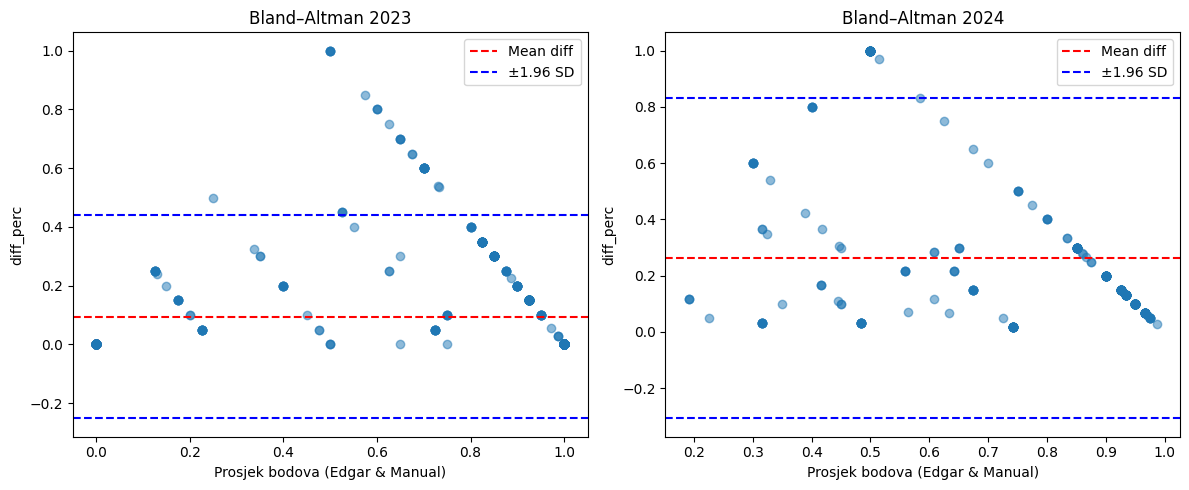

In [22]:
import numpy as np

fig, axes = plt.subplots(1, len(years), figsize=(6*len(years),5))
if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    data_year = df[df['id_academic_year']==year]
    mean_scores = (data_year['question_score_perc_ed'] + data_year['question_score_perc_man']) / 2
    diff = data_year['diff_perc']
    
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    ax.scatter(mean_scores, diff, alpha=0.5)
    ax.axhline(mean_diff, color='red', linestyle='--', label='Mean diff')
    ax.axhline(mean_diff + 1.96*std_diff, color='blue', linestyle='--', label='±1.96 SD')
    ax.axhline(mean_diff - 1.96*std_diff, color='blue', linestyle='--')
    
    ax.set_title(f'Bland–Altman {year}')
    ax.set_xlabel('Prosjek bodova (Edgar & Manual)')
    ax.set_ylabel('diff_perc')
    ax.legend()

plt.tight_layout()
plt.show()


### Tablica srednjih razlika po akademskoj godini

Prikazujemo prosječnu razliku (mean), standardnu devijaciju (std) i broj zadataka (count) po godinama.

In [23]:
summary_year = df.groupby('id_academic_year')['diff_perc'].agg(['mean','std','count']).reset_index()
summary_year.rename(columns={'mean':'mean_diff','std':'std_diff','count':'n_tasks'}, inplace=True)
display(summary_year)


,id_academic_year,mean_diff,std_diff,n_tasks
0,2023,0.094682,0.176688,676
1,2024,0.261722,0.290633,320


## 4) Analiza po ispitu

U ovom dijelu ćemo detaljnije analizirati razlike između Edgarovog i ručnog ocjenjivanja po pojedinim ispitima.
Cilj je vidjeti koji ispiti imaju najveće ili najmanje neslaganje, kako se raspoređuju razlike unutar ispita, te identificirati eventualne outliere.

### Histogrami po ispitima

Prvo ćemo vizualizirati histograme razlika (diff_perc) po ispitu, što nam daje uvid u distribuciju neslaganja i pomaže u prepoznavanju ispita s neobično velikim razlikama.

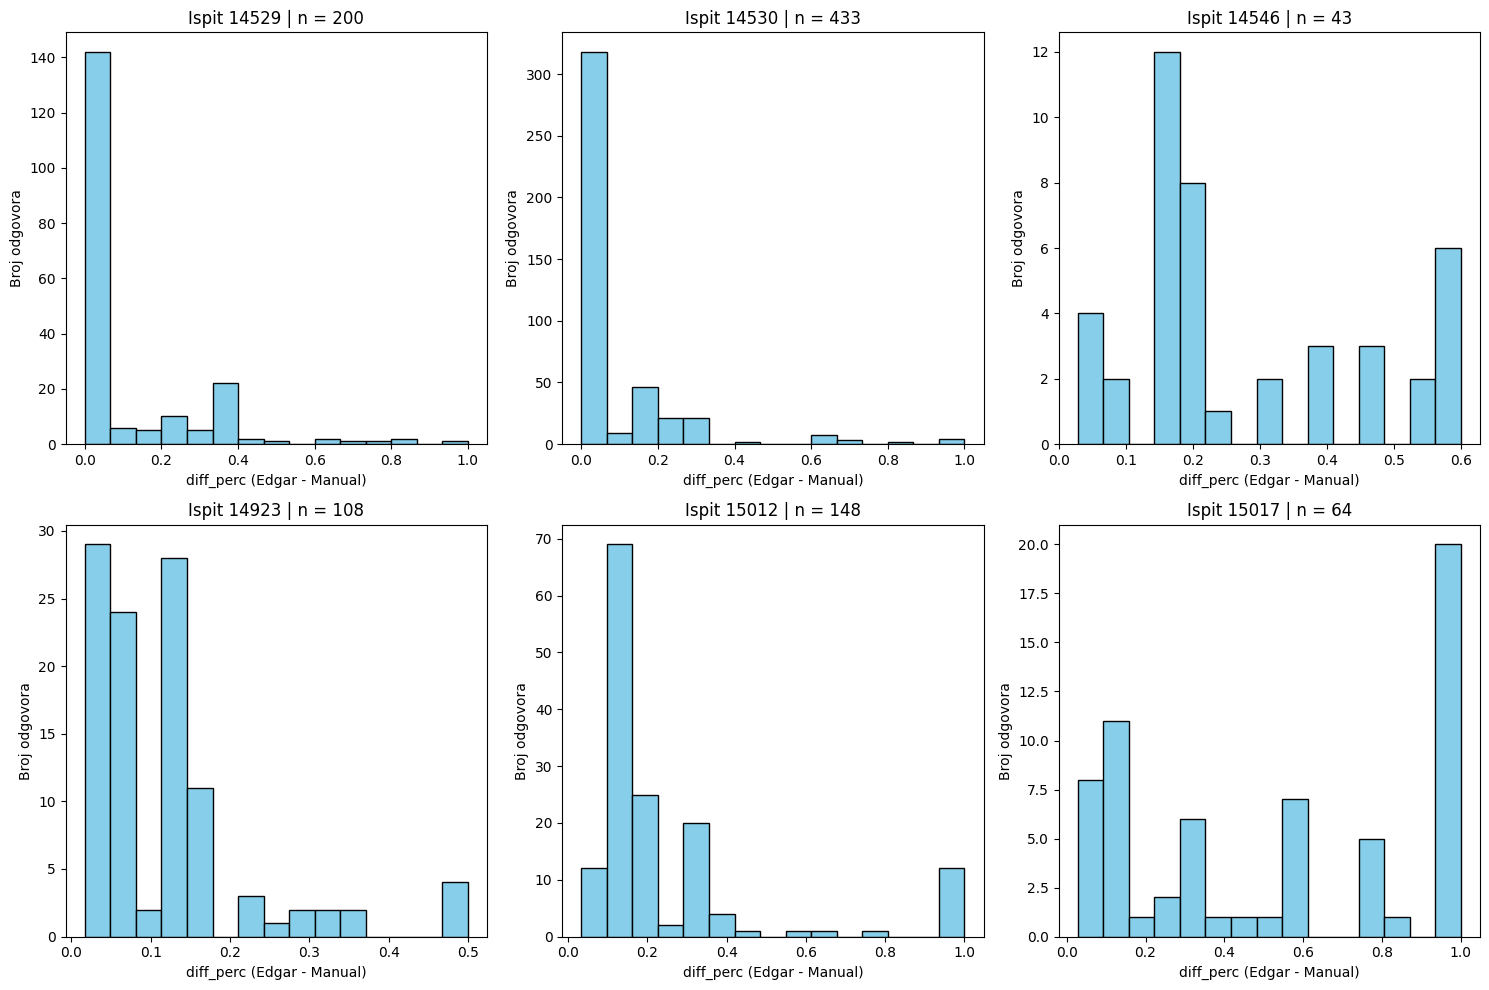

In [28]:
import matplotlib.pyplot as plt

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

cols = 3
rows = (len(data_by_test) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax, (test_id, data_struct) in zip(axes, data_by_test.items()):
    ax.hist(data_struct["diff_perc"], bins=15, color='skyblue', edgecolor='black')
    
    if "title_test" in data_struct.columns:
        title = data_struct["title_test"].iloc[0]
    else:
        title = f"Ispit {test_id}"
    
    ax.set_title(f"{title} | n = {len(data_struct)}")
    ax.set_xlabel("diff_perc (Edgar - Manual)")
    ax.set_ylabel("Broj odgovora")

for ax in axes[len(data_by_test):]:
    ax.remove()

plt.tight_layout()
plt.show()


### Ranking ispita po srednjoj i apsolutnoj srednjoj razlici

U ovom koraku želimo identificirati koji ispiti pokazuju najveću razliku između Edgarovog i manualnog ocjenjivanja. Za svaki ispit ćemo izračunati:
* Prosječnu razliku (mean diff_perc) – daje nam smjer i veličinu pristranosti
* Apsolutnu prosječnu razliku (mean abs(diff_perc)) – pokazuje koliko su ispiti problematični bez obzira na smjer

Na temelju ovih vrijednosti možemo rangirati ispita od onih s najmanjom do onih s najvećom razlikom te identificirati testove gdje automatizirani grader i manualno ocjenjivanje najviše odstupaju, što radimo u sljedećih nekoliko koraka:
1) Grupiranje podataka po ispitu (id_test)
2) Izračunavanje prosječne i apsolutne prosječne razlike diff_perc
3) Spajanje naziva ispita (title_test) radi čitljivog ispisa
4) Sortiranje i prikazivanje rankinga po mean_diff i po mean_abs_diff

In [32]:
test_stats = df.groupby("id_test")["diff_perc"].agg(
    mean_diff='mean',
    mean_abs_diff=lambda x: x.abs().mean()
).reset_index()

test_stats = test_stats.merge(
    df[["id_test", "title"]].drop_duplicates(),
    on="id_test",
    how="left"
)

test_stats_sorted_mean = test_stats.sort_values(by="mean_diff", ascending=False)
print("Ranking ispita po prosječnoj razlici (mean diff_perc):")
display(test_stats_sorted_mean[["title", "mean_diff"]])

test_stats_sorted_abs = test_stats.sort_values(by="mean_abs_diff", ascending=False)
print("Ranking ispita po apsolutnoj prosječnoj razlici (mean abs(diff_perc)):")
display(test_stats_sorted_abs[["title", "mean_abs_diff"]])


Ranking ispita po prosječnoj razlici (mean diff_perc):


,title,mean_diff
5,Ispitni rok veljača 2024/25,0.540375
2,Ispitni rok veljača 2023/24,0.275349
4,Završni ispit 2024/25 - prvi termin,0.246257
3,Međuispit 2024/25 - drugi termin,0.117787
0,Završni ispit 2023/24 - prvi termin,0.096375
1,Završni ispit 2023/24 - drugi termin,0.075958


Ranking ispita po apsolutnoj prosječnoj razlici (mean abs(diff_perc)):


,title,mean_abs_diff
5,Ispitni rok veljača 2024/25,0.540375
2,Ispitni rok veljača 2023/24,0.275349
4,Završni ispit 2024/25 - prvi termin,0.246257
3,Međuispit 2024/25 - drugi termin,0.117787
0,Završni ispit 2023/24 - prvi termin,0.096375
1,Završni ispit 2023/24 - drugi termin,0.075958


### Boxplot i analiza outliera po ispitu

U ovom dijelu vizualiziramo raspodjelu razlika između Edgarovog i ručnog ocjenjivanja (diff_perc) po pojedinom ispitu.

Ciljevi ovog koraka:
* Pomoću boxplota brzo uočiti centralne tendencije i raspon razlika po ispitu.
* Detektirati outliere, tj. ekstremne razlike između ocjenjivanja koje mogu ukazivati na pogreške ili specifične probleme u ocjenjivanju.
* Pripremiti podatke za kasniju usporedbu po ocjenjivačima unutar ispita s više ocjenjivača.
* Ovaj vizualni pregled nam omogućuje brzu identifikaciju ispita gdje se Edgar i manualno ocjenjivanje značajnije razlikuju.

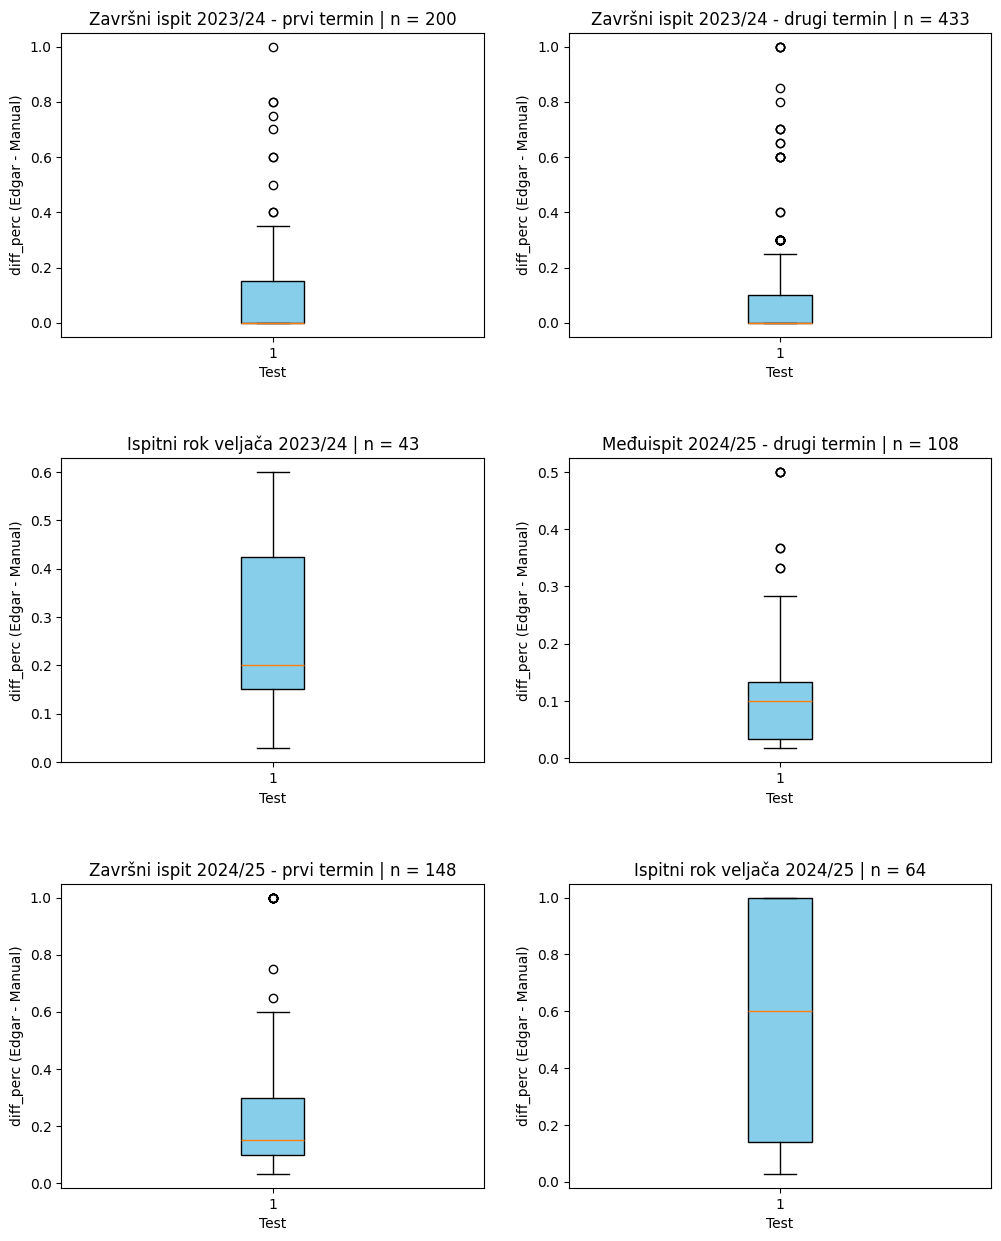

,mean,std,min,max
id_test,,,,
14529,0.096375,0.181015,0.000,1.0
14530,0.075958,0.163560,0.000,1.0
14546,0.275349,0.185115,0.028,0.6
14923,0.117787,0.108318,0.017,0.5
15012,0.246257,0.250796,0.033,1.0
15017,0.540375,0.382168,0.028,1.0


In [33]:
import matplotlib.pyplot as plt
import numpy as np

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

cols = 2
rows = int(np.ceil(len(data_by_test) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

for ax, (test_id, data_struct) in zip(axes, data_by_test.items()):
    ax.boxplot(data_struct["diff_perc"], patch_artist=True, boxprops=dict(facecolor='skyblue'))
    title = data_struct["title"].iloc[0]  # naziv ispita
    ax.set_title(f"{title} | n = {len(data_struct)}")
    ax.set_ylabel("diff_perc (Edgar - Manual)")
    ax.set_xlabel("Test")

for ax in axes[len(data_by_test):]:
    ax.remove()

plt.show()

test_stats_summary = df.groupby("id_test")["diff_perc"].agg(["mean", "std", "min", "max"])
display(test_stats_summary)


### Analiza po ocjenjivaču unutar ispita

U ovom dijelu fokusiramo se na ocjenjivače koji su radili određeni ispit.
Za svakog ocjenjivača računamo prosječnu razliku između Edgar-ovog i manualnog ocjenjivanja (diff_perc) i standardnu devijaciju.
Vizualiziramo ove vrijednosti pomoću errorbar plot-a kako bismo odmah uočili koji ocjenjivači odstupaju od automatskog ocjenjivanja.
Filtriramo ocjenjivače koji imaju premalo primjera (≤10) kako bi statistika bila pouzdana.

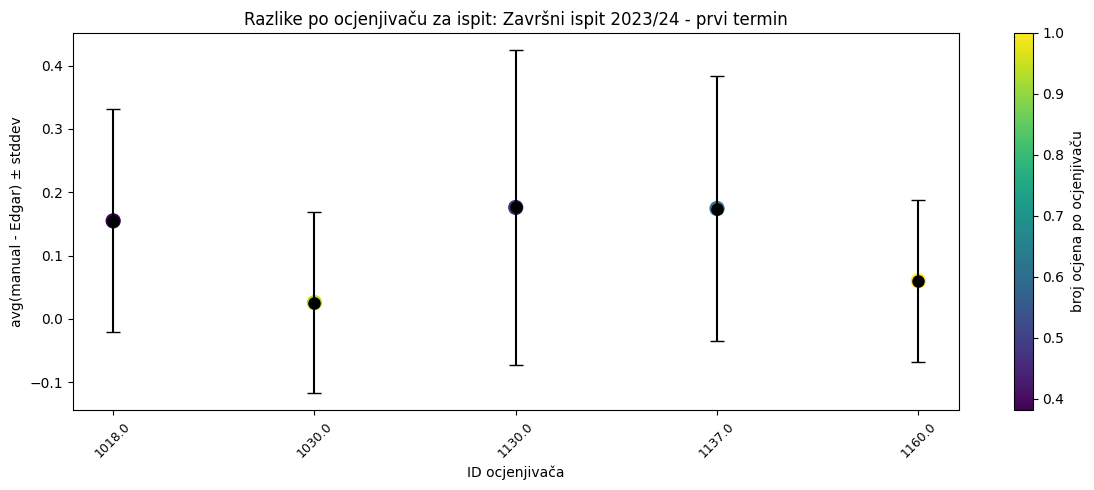

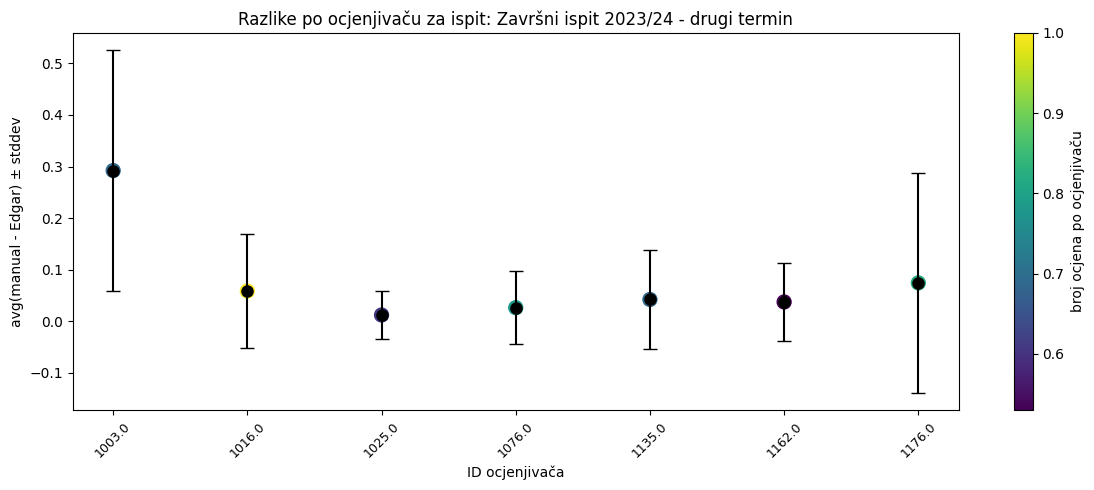

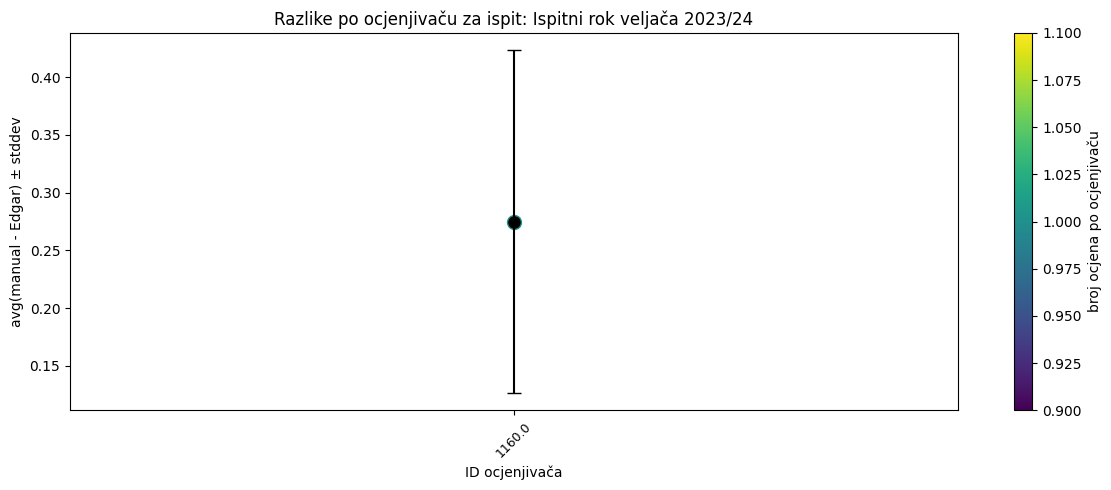

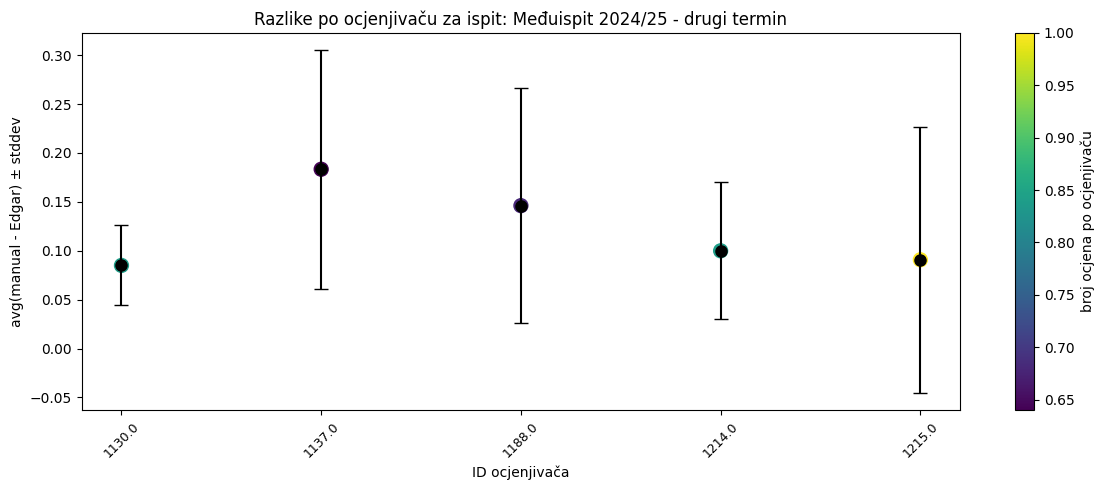

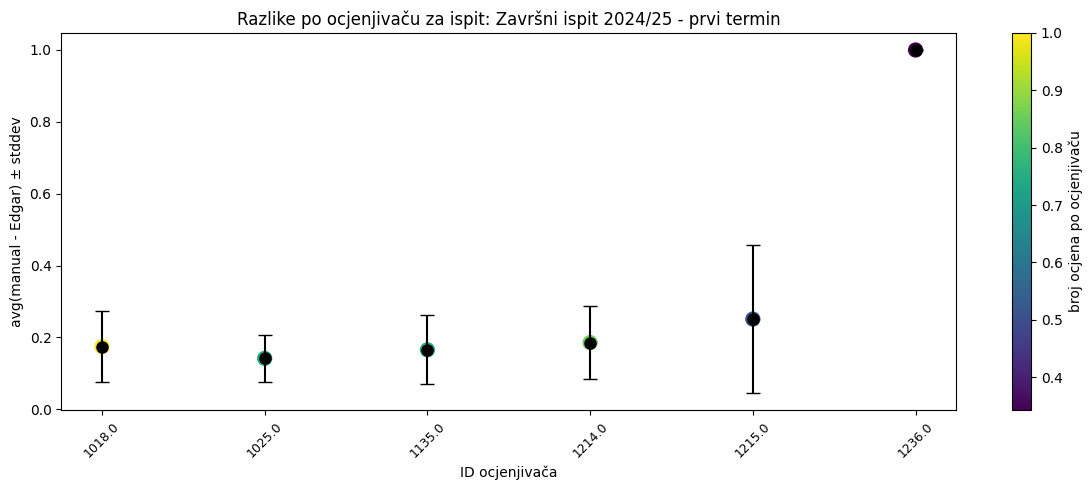

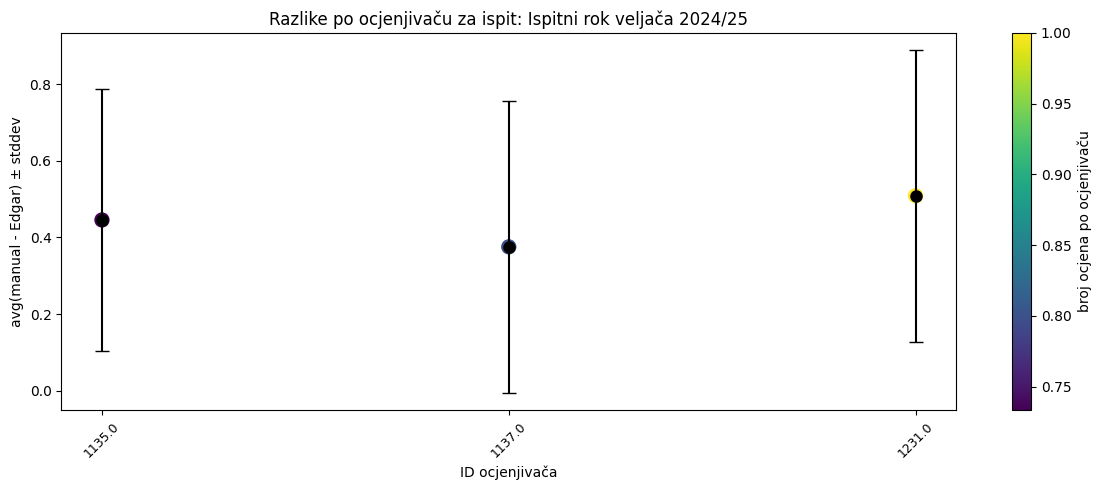

In [36]:
import matplotlib.pyplot as plt
import numpy as np

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

for test_id, data_struct in data_by_test.items():
    # Filtriramo ocjenjivače s premalo primjera
    counts_per_teacher = data_struct.groupby("id_app_user").size()
    valid_teachers = counts_per_teacher[counts_per_teacher > 10].index
    filtered_data = data_struct[data_struct["id_app_user"].isin(valid_teachers)]

    if filtered_data.empty:
        continue

    stats_by_teacher = filtered_data.groupby("id_app_user").agg(
        mean_diff=("diff_perc", "mean"),
        std_diff=("diff_perc", "std"),
        n_grades=("diff_perc", "count")
    ).reset_index()

    colors = stats_by_teacher["n_grades"] / stats_by_teacher["n_grades"].max()

    plt.figure(figsize=(12,5))
    plt.errorbar(
        x=range(len(stats_by_teacher)),
        y=stats_by_teacher["mean_diff"],
        yerr=stats_by_teacher["std_diff"],
        fmt='o',
        color='black',
        capsize=5,
        markersize=8
    )
    plt.scatter(
        x=range(len(stats_by_teacher)),
        y=stats_by_teacher["mean_diff"],
        c=colors,
        cmap='viridis',
        s=100,
        label='broj ocjena'
    )
    plt.xticks(range(len(stats_by_teacher)), stats_by_teacher["id_app_user"], rotation=45, fontsize=9)
    plt.xlabel("ID ocjenjivača")
    plt.ylabel("avg(manual - Edgar) ± stddev")
    title_name = data_struct['title'].iloc[0] if 'title' in data_struct.columns else str(test_id)
    plt.title(f"Razlike po ocjenjivaču za ispit: {title_name}")
    cbar = plt.colorbar()
    cbar.set_label('broj ocjena po ocjenjivaču')
    plt.tight_layout()
    plt.show()


## 5) Analiza po zadatku

U ovoj sekciji fokusiramo se na ponašanje razlika između automatskog i ručnog ocjenjivanja po pojedinačnim zadacima. Cilj je identificirati zadatke gdje se Edgar i učitelji najviše ne slažu te istražiti mogući utjecaj ocjenjivača na te razlike.

Analiza uključuje:
* Izračun i vizualizaciju srednje razlike po zadatku (heatmap).
* Identifikaciju Top 10 problematičnih zadataka po apsolutnoj prosječnoj razlici.
* Analizu outliera po zadatku kako bi se vidjeli ekstremni slučajevi.
* Provjeru standardne devijacije razlike po zadatku i korelaciju sa brojem ocjenjivača.

Za najproblematičnije zadatke, ponavljanje analize po ocjenjivačima kako bi se vidjelo koliko ocjenjivači doprinose razlikama.


### Heatmap srednjih razlika po zadatku

Prvi korak u analizi po zadacima je vizualizacija prosječnih razlika između Edgarovog i ručnog ocjenjivanja po svakom zadatku.
Heatmap nam omogućuje da brzo uočimo:
* Koji zadaci imaju veće ili manje neslaganje između automatiziranog i manualnog ocjenjivanja.
* Obrasce koji se možda ponavljaju unutar testova ili po tipu zadatka.

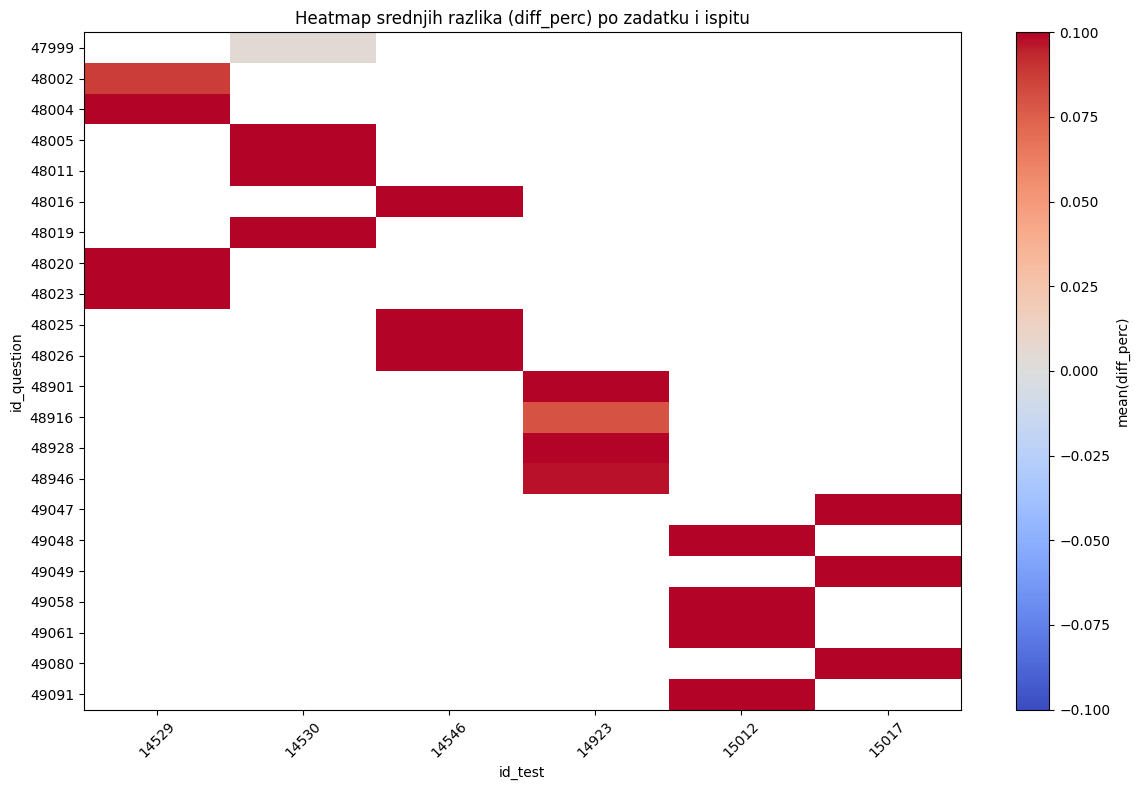

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

task_stats = df.groupby(["id_test", "id_question"])["diff_perc"].mean().unstack(level=0)

max_abs = np.abs(task_stats.values).max()

plt.figure(figsize=(12, 8))

plt.imshow(task_stats, aspect='auto', cmap='coolwarm', vmin=-max_abs, vmax=max_abs)
plt.colorbar(label='mean(diff_perc)')

plt.xticks(ticks=np.arange(len(task_stats.columns)), labels=task_stats.columns, rotation=45)
plt.yticks(ticks=np.arange(len(task_stats.index)), labels=task_stats.index)

plt.title("Heatmap srednjih razlika (diff_perc) po zadatku i ispitu")
plt.xlabel("id_test")
plt.ylabel("id_question")
plt.tight_layout()
plt.show()


### Top 10 problematičnih zadataka i analiza njihovih ocjenjivača

U ovom dijelu identificiramo 10 zadataka koji pokazuju najveće razlike između Edgarovog i manualnog ocjenjivanja.
Cilj je vidjeti koji zadaci izazivaju najveću neslaganje te provjeriti utjecaj ocjenjivača na te zadatke.

Analiza uključuje:
* Rangiranje zadataka po apsolutnoj prosječnoj razlici (diff_perc)
* Prikaz broja različitih ocjenjivača po zadatku
* Analizu prosječne razlike i standardne devijacije po ocjenjivaču za svaki od problematičnih zadataka

Top 10 problematičnih zadataka po apsolutnoj razlici:


,mean_diff,mean_abs_diff,std_diff
id_question,,,
49049,1.000000,1.000000,0.000000
49058,0.775000,0.775000,0.450000
49048,0.710000,0.710000,0.406817
49047,0.702000,0.702000,0.305986
48016,0.435294,0.435294,0.168208
48004,0.400000,0.400000,NaN
48011,0.276087,0.276087,0.209326
49091,0.273582,0.273582,0.203981
48019,0.268750,0.268750,0.310458


Broj različitih ocjenjivača po top 10 zadataka:


id_question
49049    1
49058    2
49048    3
49047    8
48016    8
48004    1
48011    5
49091    7
48019    3
48026    1
Name: id_app_user, dtype: int64

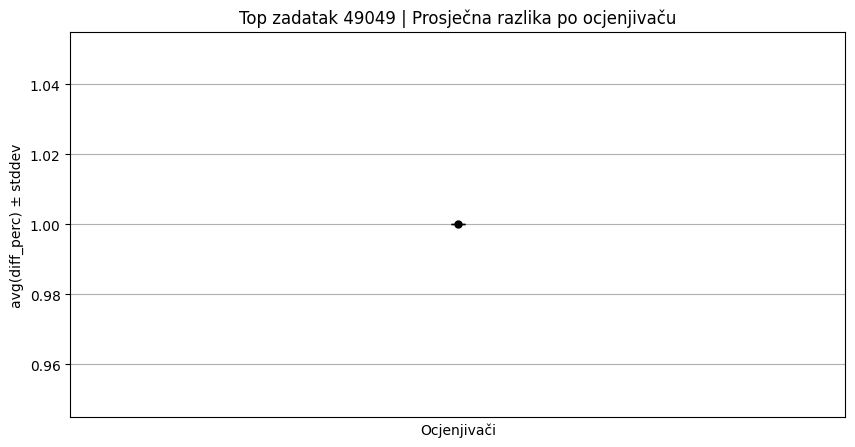

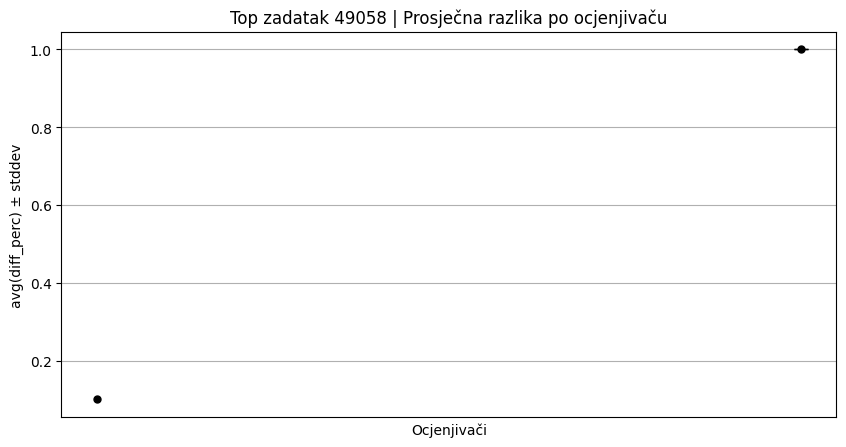

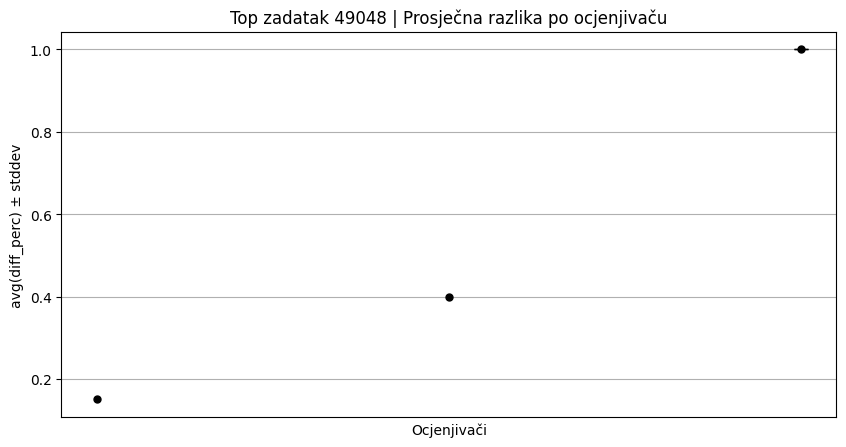

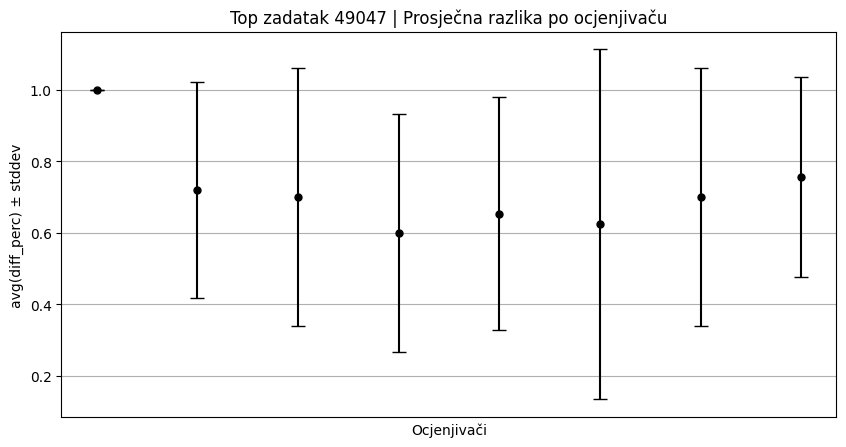

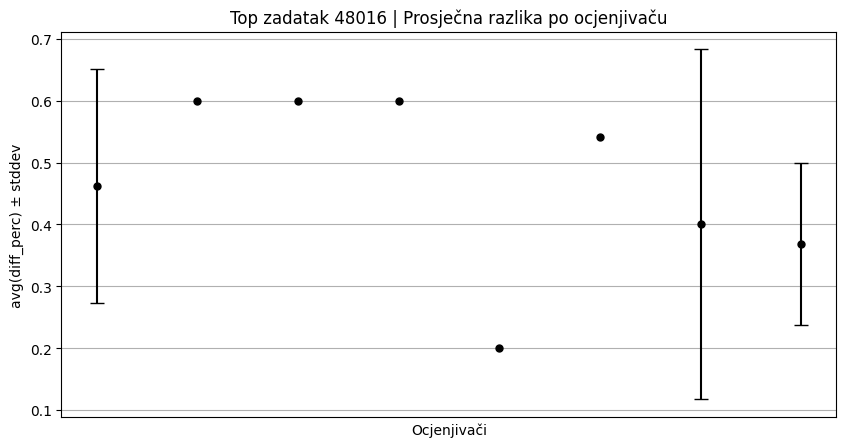

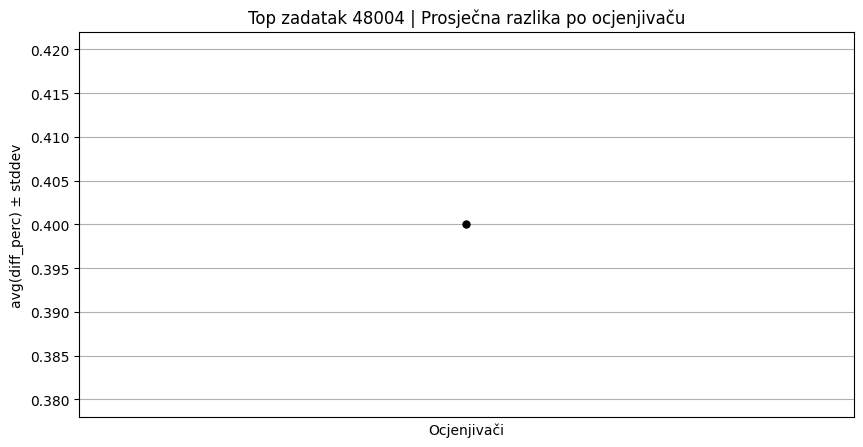

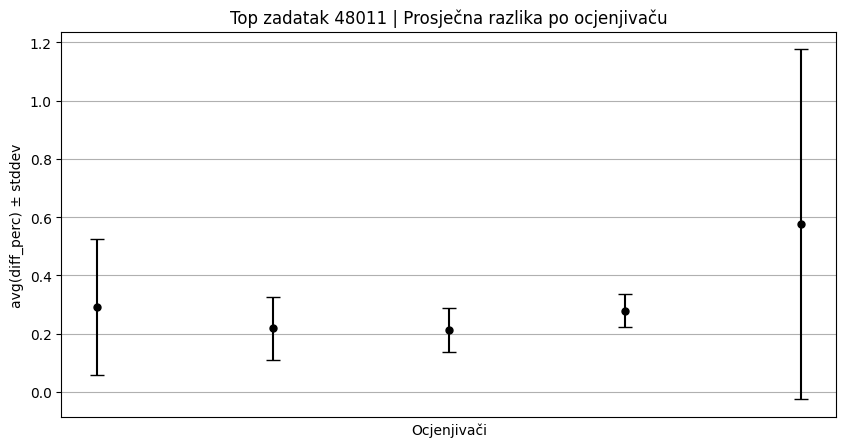

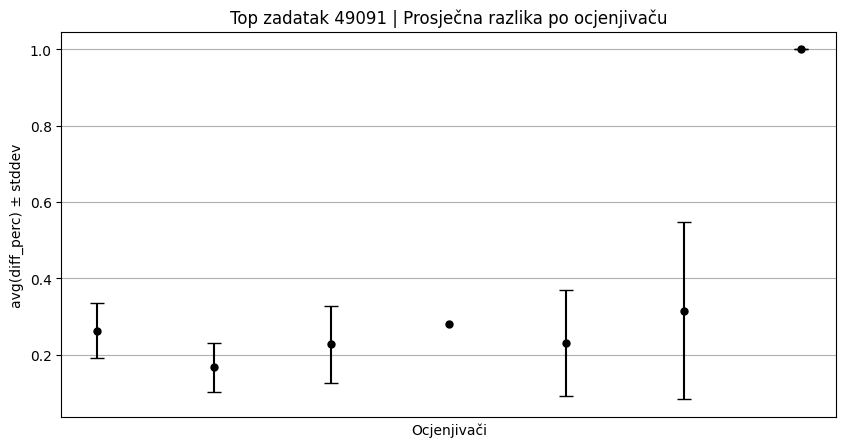

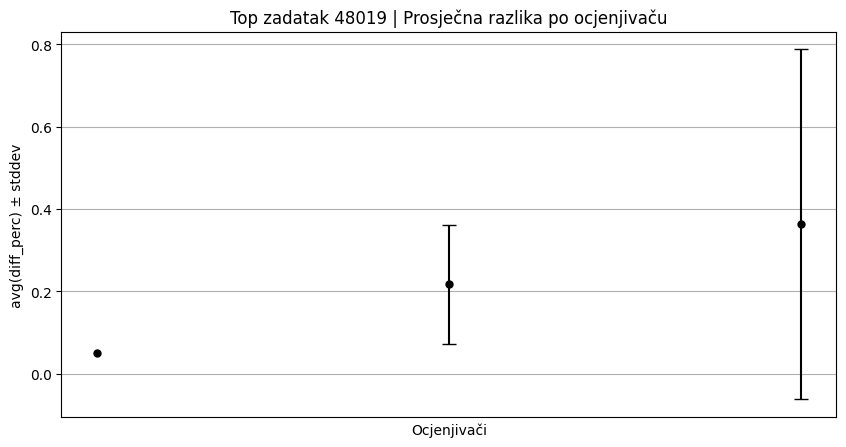

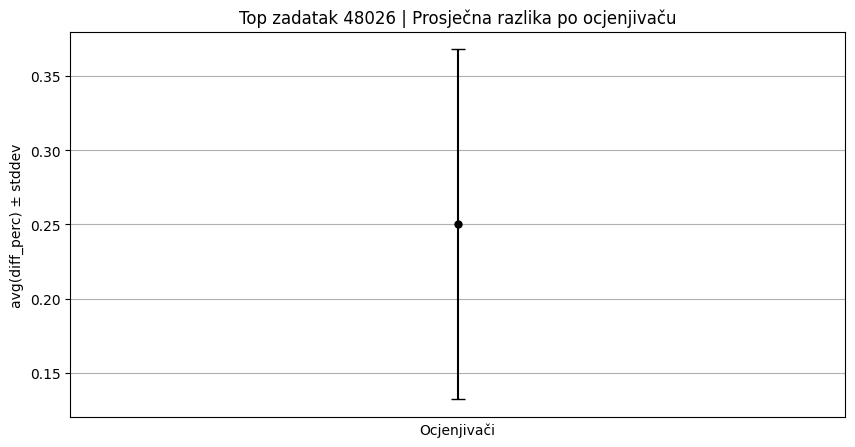

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

task_stats = df.groupby("id_question")["diff_perc"].agg(
    mean_diff="mean",
    mean_abs_diff=lambda x: x.abs().mean(),
    std_diff="std"
).sort_values(by="mean_abs_diff", ascending=False)

top10_tasks = task_stats.head(10)
print("Top 10 problematičnih zadataka po apsolutnoj razlici:")
display(top10_tasks)

teachers_per_task = df.groupby("id_question")["id_app_user"].nunique()
print("Broj različitih ocjenjivača po top 10 zadataka:")
display(teachers_per_task.loc[top10_tasks.index])

for task_id in top10_tasks.index:
    task_data = df[df["id_question"] == task_id].dropna(subset=["id_app_user"])
    stats_by_teacher = task_data.groupby("id_app_user")["diff_perc"].agg(
        mean_diff="mean",
        std_diff="std"
    )
    
    x_pos = range(len(stats_by_teacher))
    y = stats_by_teacher["mean_diff"]
    yerr = stats_by_teacher["std_diff"]
    
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_pos, y, yerr=yerr, fmt='o', color='black', capsize=5, markersize=5)
    plt.xticks([])
    plt.xlabel("Ocjenjivači")
    plt.ylabel("avg(diff_perc) ± stddev")
    plt.title(f"Top zadatak {task_id} | Prosječna razlika po ocjenjivaču")
    plt.grid(True)
    plt.show()


### Standardna devijacija po zadatku i korelacija s brojem ocjenjivača

U ovom koraku analiziramo koliko se razlikuju razlike između Edgara i ručnog ocjenjivanja po zadacima. Za svaki zadatak računamo:
* Standardnu devijaciju (std) razlika (diff_perc) – pokazuje varijabilnost ocjenjivanja po zadatku.
* Broj ocjenjivača po zadatku – koliko različitih učitelja je ocijenilo pojedini zadatak.
* Korelaciju između standardne devijacije i broja ocjenjivača – pomaže nam vidjeti postoji li veća varijabilnost kod zadataka koje ocjenjuje veći broj ocjenjivača.

Ova analiza daje globalni uvid u stabilnost ocjenjivanja i identificira zadatke koji mogu zahtijevati dodatnu pažnju.

Korelacija između standardne devijacije razlika i broja ocjenjivača po zadatku: -0.057


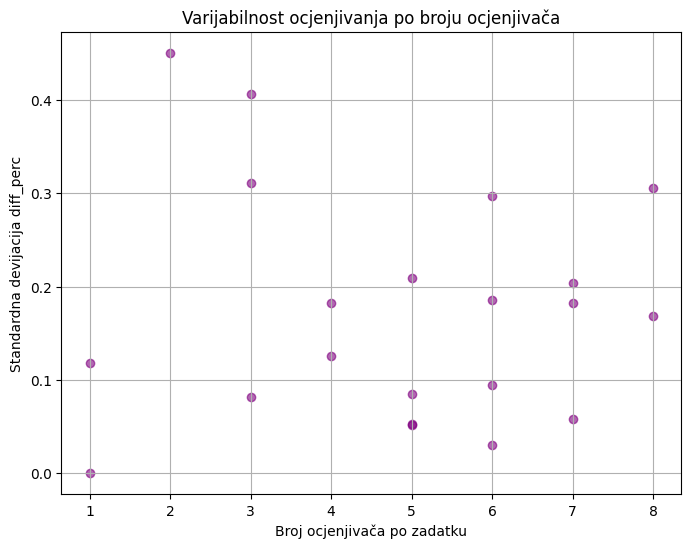

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

std_by_task = df.groupby("id_question")["diff_perc"].std().rename("std_diff")

teachers_per_task = df.groupby("id_question")["id_app_user"].nunique().rename("n_teachers")

task_stats = pd.concat([std_by_task, teachers_per_task], axis=1).dropna()

corr = task_stats["std_diff"].corr(task_stats["n_teachers"])
print(f"Korelacija između standardne devijacije razlika i broja ocjenjivača po zadatku: {corr:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(task_stats["n_teachers"], task_stats["std_diff"], alpha=0.6, color='purple')
plt.xlabel("Broj ocjenjivača po zadatku")
plt.ylabel("Standardna devijacija diff_perc")
plt.title("Varijabilnost ocjenjivanja po broju ocjenjivača")
plt.grid(True)
plt.show()


## 6) Zaključak